In [1]:
import os
import sys

import numpy as np
from skimage.io import imread

sys.path.append('..')
# %matplotlib notebook
from utils.data_processing import set_generator_classifier
from utils.visualisers import plot_images
from src.vyn_augment.augmentor import Augmentor

In this example, we will make use of the generator in the utils directory. This generator takes as input a list of tuples, where the first value is a label and the rest are whatever the user needs to create a batch of images and process the data. Then, it randomly selects a tuple from the list and pass it to a function that the user must provide. This function named `preprocessing_function`, will take the tuple and will return a processed image and the ground truth of the model output. In this example, since we are dealing with object detection, the output will be the bounding boxes. However, this output may be different depending on the type of detector and it usually changes more than for classification or segmentation.

Lastly, the generator will joined a set of processed images and the other data and return a batch at each iteration.

In [2]:
def pre_processing_function(label, filename: str, augmentor: Augmentor = None):
    """
    Pre-processing function. This function is run within the generator, which calls it for each individual image
    regardless the batch size.
    :param label: Anything that can be used as a identification for the image type.
    :param filename: The complete path to the image file. This function will read the image into a numpy array.
    :param augmentor: An object of type Augmentor
    :return:
    """
    image = imread(filename)
    if augmentor is not None:
        image = np.round(augmentor.run(image)).astype(np.uint8)

    return image, label

`vyn_augment` employs a dictionary with the transformation as keys and the inputs as values or another dictionary with keys `values` and the extra keys. The main reason to use this second approach is to change the probability of the transformation to be used.

In the case of classification, only the images needs to be augmented. As usual if the same augmentation must be performed more than once, for instance we want to rotate an image between -15 and 15 degrees or between 30 and 45 degrees, the key with the name `rotate` can have any number after it.
```
{
...
'rotate': (-15, 15),
'rotate1': (30, 45),
...
}
```
Another example is the brightness operation in the function `set_augmentor()` below. If the operations should not be used in the same augmentation (It should select between rotate and rotate1 and not both of them), use the `no_repetition` flag when creating the Augmentor object. 

For the meaning of the values, check the `README.md`.

In [3]:
def set_augmentor():
    """
    Set the augmentor.
    1. Select the operations and create the config dictionary
    2. Pass it to the Augmentor class with any other information that requires
    3. Return the instance of the class.
    :return:
    """
    config = {'blur': {'values': ('gaussian', 0.7, 1.0), 'prob': 0.3},
              'brightness': {'values': (0.6, 1.0), 'prob': 0.1},
              'brightness1': {'values': (1.0, 1.5), 'prob': 0.1},
              'flip': {'values': ('hor',), 'prob': 0.5},
              'grid_mask': {'values': (0, 0.2, 0, 0.2, 0.01, 0.1, 0.01, 0.1, 0.1, 0.2, 0.1, 0.2), 'prob': 0.4},
              'illumination': {'values': ('blob_negative', 0.1, 0.2, 100, 150), 'prob': 0.2},
              'noise': {'values': (2, 10), 'use_gray_noise': True, 'prob': 1},
              'rotate': {'values': (-45, 45), 'prob': 0.4},
              'translate': {'values': ('RANDOM', -0.2, 0.2), 'prob': 0.2, 'use_replication': True},
              'zoom': {'values': (0.5, 1.5), 'prob': 0.9, 'use_replication': True}}

    augmentor = Augmentor(config)

    return augmentor

The use case performs the following operations:
1. Get the augmentor using set_augmentor()
2. Get the generator with set_generator()
3. Get the augmented images and plot them

The process may take a while and should print as many images as the hyper parameter n below. The function `plot_images` will create a figure with 4 columns and `ceil(n/4)` rows.

In [4]:
data_dirname = '../images/classification'
n = 20  # Number of images to create

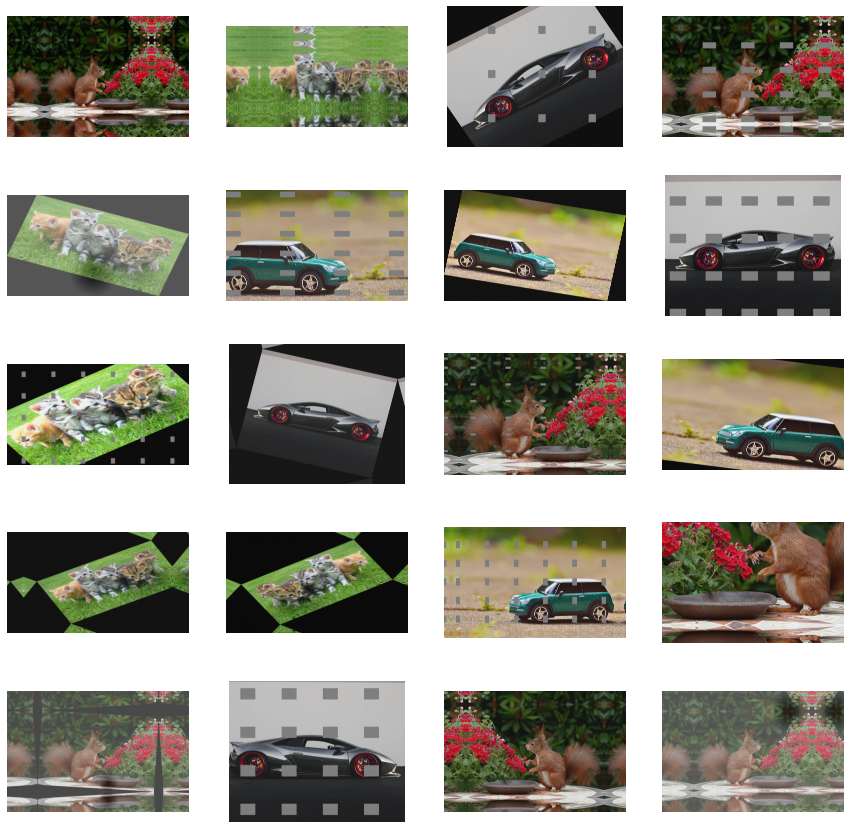

In [8]:
augmentor = set_augmentor()
preprocessing_fun = lambda *args: pre_processing_function(*args, augmentor=augmentor)
generator = set_generator_classifier(data_dirname, preprocessing_fun, batch_size=1, number_of_images=n)
generator.not_batch = True
# NOTICE: This generator can be used for keras and pytorch in case that instead of saving images one desires to
# augment images on the fly. Use a number larger than 1 for the batch size when training directly a CNN.

# Save the new generated images
counter_labels = {}
images = []
for image, label in generator:
    images.append(image)

plot_images(images, figsize=(15, 3*(n//4)))